In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score

C:\Users\Joheen\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

ymaster = pd.DataFrame()
xmaster = pd.DataFrame()

# Import data
def readadddata(filename):
    global xmaster
    global ymaster
    data = pd.read_csv(filename)
    data = data.drop(['Base'], 1)
    datetimes = data['Date/Time']
    dayofweek = []
    hour = []
    for s in datetimes:
        day = int(s.split('/')[1])%7
        dayofweek.append(day)
        time = int(s.split()[1].split(':')[0])*60+(int(s.split()[1].split(':')[1]))
        hour.append(time)
    data['dayofweek']=dayofweek
    data['hour']=hour
    df = data.drop(['Date/Time'], 1)
    y=df.drop('dayofweek', 1).drop('hour', 1)
    x=df.drop('Lat', 1).drop('Lon', 1)
    xmaster = pd.concat([xmaster, x])
    ymaster = pd.concat([ymaster, y])
    
readadddata('rides_data.csv')
readadddata('uber-raw-data-apr14.csv')
readadddata('uber-raw-data-aug14.csv')
readadddata('uber-raw-data-jul14.csv')
readadddata('uber-raw-data-jun14.csv')
readadddata('uber-raw-data-may14.csv')
ymaster.shape

(4534327, 2)

In [21]:
xtrain=xmaster[0:3600000]
ytrain=ymaster[0:3600000]
xtest=xmaster[3600000:4534327]
ytest=ymaster[3600000:4534327]
ytest.size

1868654

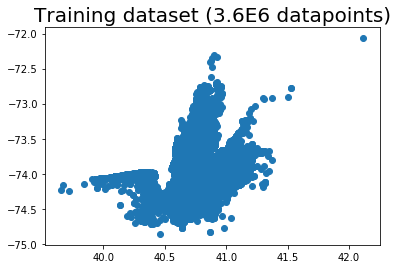

In [17]:
import matplotlib.pyplot as plt
plt.scatter(ytrain[['Lat']], ytrain[['Lon']])
plt.title("Training dataset (3.6E6 datapoints)", fontsize=20)
plt.show()

In [31]:
from sklearn.tree import DecisionTreeRegressor
parameters = {'min_samples_leaf': 3,
              'min_samples_split': 10,
              'max_features': 'sqrt',
              'max_depth': 6,
              'max_leaf_nodes': None}
RF_model = DecisionTreeRegressor(**parameters)
RF_model.fit(xtrain, ytrain)
RF_predictions = RF_model.predict(xtest)

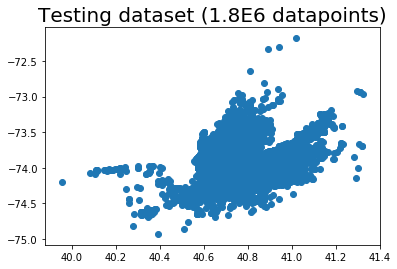

In [26]:
import matplotlib.pyplot as plt
plt.scatter(ytest[['Lat']], ytest[['Lon']])
plt.title("Testing dataset (1.8E6 datapoints)", fontsize=20)
plt.show()

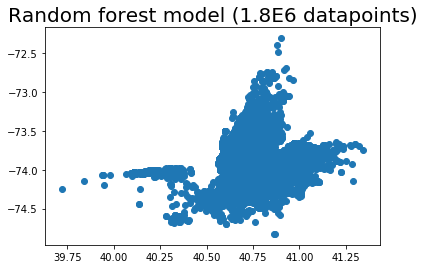

In [36]:
# plt.scatter(ytest1[['Lat']], ytest1[['Lon']])
plt.scatter(RF_predictions[:,0], RF_predictions[:,1])
plt.title("Random forest model (1.8E6 datapoints)", fontsize=20)
plt.show()

In [37]:
#RANDOM FOREST REGRESSION SCORE: the average of the mean squared error of the latitude and the mean squared error of longitude
std = np.std(ytestmini.values[:,0])
# print(mean(RF_predictions[:,0])/mean(ytestmini.values[:,0]))

sigmalat = 0
c=0
for y in ytestmini.values[:,0]:
    sigmalat += (y-RF_predictions_mini[:,0][c])**2
    c += 1
mselat = (1/ytestmini.size)*(sigmalat)
print("Mean-squared-error, latitude: " + str(mselat))

sigmalon = 0
c=0
for y in ytestmini.values[:,1]:
    sigmalon += (y-RF_predictions_mini[:,1][c])**2
    c += 1
mselon = (1/ytestmini.size)*(sigmalon)
print("Mean-squared-error, longitude: " + str(mselon))

Mean-squared-error, latitude: 0.0008419197161084177
Mean-squared-error, longitude: 0.002735911888644866


In [64]:
time = 500 #IN THE APP, THESE NUMBERS
day = 4    #ARE INPUTTED BY THE USER


xtimes = xmaster.loc[xmaster['hour']-time <= 5]
ytimes = ymaster.loc[xmaster['hour']-time <= 5] #gets all rides within 5 minutes
yrel = ytimes.loc[xtimes['dayofweek'] == day] #gets relevant x's

minlat = (ymaster['Lat'].values.min())
minlon = (ymaster['Lon'].values.min())
maxlat = (ymaster['Lat'].values.max())
maxlon = (ymaster['Lon'].values.max())

uniformgrid = []
latit = minlat
lonit = minlon
while lonit <= maxlon:
    while latit<=maxlat:
        zone = []
        zone.append(latit)
        zone.append(lonit)
        latit += .01449 #corresponds to 1 mile, latitude
        zone.append(latit)
        zone.append(lonit+.01455) #corresponds to 1 mile, longitude
        uniformgrid.append(zone)
    lonit += .01455
    latit=minlat
    
hotspots = np.zeros((170, 197)) #dimensions of uniformgrid

for index, row in yrel.iterrows():
    lat = row['Lat']
    lon = row['Lon']
    latbin = int((lat-minlat)/.01449)
    lonbin = int((lon-minlon)/.01455)
    
    hotspots[latbin][lonbin] += 1

    
finalout = []
for x in hotspots:
    for y in x:
        if y > hotspots.mean() + 5*hotspots.std():
            uWu = []
            uWu.append(y)
            uWu.append(uniformgrid[x.tolist().index(y)*170+hotspots.tolist().index(x.tolist())][0]+.01449/2)
            uWu.append(uniformgrid[x.tolist().index(y)*170+hotspots.tolist().index(x.tolist())][1]+.01455/2)
            finalout.append(uWu)
            
print(sorted(finalout,key=lambda x: x[0]))

[[568.0, 40.64946500000014, -73.77227500000001], [643.0, 40.678445000000146, -73.990525], [651.0, 40.79436500000016, -73.961425], [661.0, 40.69293500000015, -73.975975], [674.0, 40.69293500000015, -74.179675], [716.0, 40.70742500000015, -73.990525], [721.0, 40.69293500000015, -73.961425], [763.0, 40.70742500000015, -74.019625], [824.0, 40.678445000000146, -73.961425], [899.0, 40.678445000000146, -73.975975], [928.0, 40.76538500000016, -73.946875], [944.0, 40.70742500000015, -73.946875], [981.0, 40.750895000000156, -73.961425], [1150.0, 40.70742500000015, -73.961425], [1291.0, 40.72191500000015, -73.946875], [1326.0, 40.77987500000016, -73.990525], [1408.0, 40.69293500000015, -73.990525], [1675.0, 40.72191500000015, -73.961425], [1798.0, 40.64946500000014, -73.78682500000001], [1898.0, 40.79436500000016, -73.975975], [2011.0, 40.72191500000015, -73.975975], [2160.0, 40.70742500000015, -74.005075], [2530.0, 40.77987500000016, -73.961425], [2617.0, 40.750895000000156, -74.005075], [3224.0

In [67]:
export = []
for oWo in finalout:
    export.append(str(oWo[1]) + "," + str(oWo[2]))

print(export)
p

['40.64946500000014,-73.78682500000001', '40.64946500000014,-73.77227500000001', '40.678445000000146,-73.990525', '40.678445000000146,-73.975975', '40.678445000000146,-73.961425', '40.69293500000015,-74.179675', '40.69293500000015,-73.990525', '40.69293500000015,-73.975975', '40.69293500000015,-73.961425', '40.70742500000015,-74.019625', '40.70742500000015,-74.005075', '40.70742500000015,-73.990525', '40.70742500000015,-73.961425', '40.70742500000015,-73.946875', '40.72191500000015,-74.005075', '40.72191500000015,-73.990525', '40.72191500000015,-73.975975', '40.72191500000015,-73.961425', '40.72191500000015,-73.946875', '40.736405000000154,-74.005075', '40.736405000000154,-73.990525', '40.736405000000154,-73.975975', '40.750895000000156,-74.005075', '40.750895000000156,-73.990525', '40.750895000000156,-73.975975', '40.750895000000156,-73.961425', '40.76538500000016,-73.990525', '40.76538500000016,-73.975975', '40.76538500000016,-73.961425', '40.76538500000016,-73.946875', '40.779875000